
# torch优化器的源码解读

主要涉及到 `torch.optim`包下的`optimizer.py`的`optimizer` 基类

参考[torch.optim.optimizer class](https://pytorch.org/docs/stable/optim.html?highlight=optimizer#torch.optim.Optimizer) 以及 [分模块学习率赋值](https://blog.csdn.net/weixin_43593330/article/details/108491755)
[weight和bias学习率](https://blog.csdn.net/qq_17464457/article/details/101846874)



平时我们所用的优化器都是在torch.optim包下所定义的，比如SGD, Adam两个优化器.
这两个优化器都是以torch.optim.optimizer.py包下的optimzer为基类，该类定义了如下的几个重要attri:

* 1. self.__getstate__(), self.__setstate__() 参考 动手学python的说明文(目的是为了方便自定义打包)
* 2. self.state_dict(), self.load_state_dict(): 和`nn.Moudle`类一致，得到优化器的state,便于打包和按照打包的优化器超参数
    进行下一次的相同优化
* 3. self.step(): 优化更新(利用梯度下降法更新公式)
* 4. self.add_param_groups(): 打包权重和bias到优化器的'params_group'参数

基于上述的优化器类，我们可以得到优化器的结构如下：

```
optim
-- defaults:--> dict{'lr': , 'momentum': , 'weight_decay': , ...}
-- state:这个一般不管
-- param_groups: --> list[{}, {}, {}] (如果是不分组，比如 优化器的参数为model.parameters()的迭代器，则
                            全部的参数都是共享学习率和decay;  但是如果要分组，那么就按照每一个组
                                为一个list的元素，每个下标数据为一个dict：
                                'params': {list} (权重和bias都分别为一个数据点)
                                'lr':
                                'weight_decay':
                                ...)
```


因此在进行优化器参数赋值的时候，最关键的就是组织好'param'参数，其形式为:
[{'params': [Parameter]}, {'params': [Parameter]}, {},...]

```
**注意**:

1.优化器的`param`参数可以是tensor的迭代器,也可以是dict.
2. If you need to move a model to GPU via .cuda(), please do so before constructing optimizers for it. Parameters of a model after .cuda() will be different objects with those before the call.
    In general, you should make sure that optimized parameters live in consistent locations when optimizers are constructed and used.
```


In [4]:

# 模型以及基本的最简单优化器搭建

import torch.optim as optim
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

class CivilNet(nn.Module):
    def __init__(self):
        super(CivilNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 22 * 22, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc = nn.Sequential(nn.Linear(84, 10),
                                nn.ReLU(),
                                nn.Linear(10,2))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 22 * 22)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc(x)
        return x
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CivilNet().to(device)

opt = optim.SGD(model.parameters(), lr=0.1) 
print(
    opt
)

input = torch.randn((1,3,100,100))
input = input.to(device)

loss_fn = nn.MSELoss()

for i in range(3):
    opt.zero_grad()
    output = model(input)
    label = torch.empty(1, 2, dtype=torch.float).random_(5).to(device)
    loss = loss_fn(output, label)
    loss.backward()
    opt.step()
    print(i)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.1
    momentum: 0
    nesterov: False
    weight_decay: 0
)
0
1
2



## 分模块进行学习率的赋值

参考[官方文档说明](https://pytorch.org/docs/stable/optim.html?highlight=optimizer#torch.optim.Optimizer)

In [8]:

lr = 1e-3
conv1_params = list(map(id, model.conv1.parameters()))
conv2_params = list(map(id, model.conv2.parameters()))
base_params = filter(lambda p: id(p) not in conv1_params + conv2_params, model.parameters())
base_pa = list(base_params)
print(len(base_pa))
params = [{'params': base_pa},
          {'params': list(model.conv1.parameters()), 'lr': lr * 1.5},
          {'params': list(model.conv2.parameters()), 'lr': lr * 2.0}]

opt2 = torch.optim.SGD(params, lr=lr, momentum=0.9)
print(opt2)
input = torch.randn((1,3,100,100))
input = input.to(device)

loss_fn = nn.MSELoss()

for i in range(3):
    opt.zero_grad()
    output = model(input)
    label = torch.empty(1, 2, dtype=torch.float).random_(5).to(device)
    loss = loss_fn(output, label)
    loss.backward()
    opt.step()
    print(i)

8
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 0

Parameter Group 1
    dampening: 0
    lr: 0.0015
    momentum: 0.9
    nesterov: False
    weight_decay: 0

Parameter Group 2
    dampening: 0
    lr: 0.002
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
0
1
2



## 分weight和bias的学习率

合理利用nn.Moudle的parameters()方法得到不同组的参数,然后设置学习率



In [5]:
lr = 0.001
params = []
fc_params = dict(model.fc.named_parameters())
for key, value in fc_params.items():
        if 'bias' not in key:
            params += [{'params': [value], 'lr': lr}]
        else:
            params += [{'params': [value], 'lr': lr * 0.1}]
conv4_param = dict(model.conv1.named_parameters())
for key, value in conv4_param.items():
        if 'bias' not in key:
            params += [{'params': [value], 'lr': lr}]
        else:
            params += [{'params': [value], 'lr': lr * 0.1}]

params += [{'params': model.conv2.parameters(), 'lr': lr * 0.1}]
conv1_id = list(map(id, model.conv1.parameters()))
conv2_id = list(map(id, model.conv2.parameters()))
fc_id = list(map(id,model.fc.parameters()))
base_param = list(filter(lambda p: id(p) not in conv1_id+ conv2_id+ fc_id, model.parameters()))

params += [{'params': base_param, 'lr': lr*0.2}]

opt= optim.Adam(params)

print(opt)
input = torch.randn((1,3,100,100))
input = input.to(device)

loss_fn = nn.MSELoss()

for i in range(3):
    opt.zero_grad()
    output = model(input)
    label = torch.empty(1, 2, dtype=torch.float).random_(5).to(device)
    loss = loss_fn(output, label)
    loss.backward()
    opt.step()
    print(i)
    

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0

Parameter Group 2
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0

Parameter Group 3
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0

Parameter Group 4
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0

Parameter Group 5
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0

Parameter Group 6
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0

Parameter Group 7
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0002
    weight_decay: 0
)
0
1
2



##根据迭代次数调整学习率


当我们知道了optimizer的设置和分组之后，其实我们只需要在其'params_group'下的每一个组进行学习率即'lr'的关键值
修改即可


In [9]:

def adjust_learning_rate(optimizer, epoch, lr):
    """Sets the learning rate to the initial LR decayed by 10 every 2 epochs"""
    lr *= (0.1 ** (epoch // 2))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


0 1.0000000000000007e-15
1 1.0000000000000007e-15
2 1.0000000000000007e-16
3 1.0000000000000007e-16
4 1.0000000000000008e-17
5 1.0000000000000008e-17
6 1.0000000000000008e-18
7 1.0000000000000008e-18
8 1.0000000000000008e-19
9 1.0000000000000008e-19


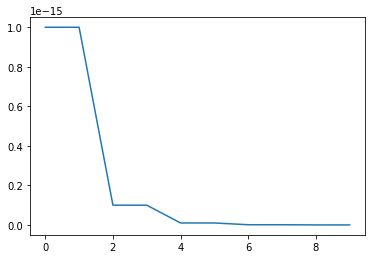

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
lr0_init = opt2.param_groups[0]['lr']
y = []
for epoch in range(10):
    adjust_learning_rate(opt2, epoch, lr0_init)
    lr = opt2.param_groups[0]['lr']
    print(epoch, lr)
    y.append(lr)

plt.plot(list(range(10)),y)